In [1]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow import gradients
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Load the input data, their corresponding class labels, and the ROI mask
data = np.load("data/data.npy")
labels= np.load("data/labels.npy")
rois = np.load("data/maskROI.npy")

In [4]:
#Randomly split the data
index = np.random.RandomState(seed=1).permutation(9000)
all_data = data[index]
all_labels = labels[index]
train_data = all_data[0:8800]
train_labels= all_labels[0:8800][:,0]-1
val_data = all_data[8800:8900]
val_labels= all_labels[8800:8900][:,0]-1
test_data = all_data[8900:9000]
test_labels= all_labels[8900:9000][:,0]-1

In [5]:
#Get indices for inputs from each class
where_train_0 = np.where(train_labels==0)
where_train_1 = np.where(train_labels==1)
where_train_2 = np.where(train_labels==2)
where_val_0 = np.where(val_labels==0)
where_val_1 = np.where(val_labels==1)
where_val_2 = np.where(val_labels==2)
where_test_0 = np.where(test_labels==0)
where_test_1 = np.where(test_labels==1)
where_test_2 = np.where(test_labels==2)

In [6]:
#Load the template images for the three classes
temp_0 = np.load("data/classPrototype1.npy")
temp_1 = np.load("data/classPrototype2.npy")
temp_2 = np.load("data/classPrototype3.npy")
temp_avg = (temp_0+temp_1+temp_2)/3.0

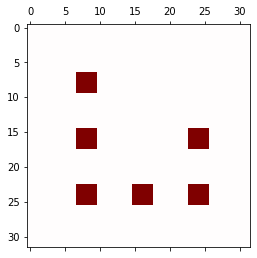

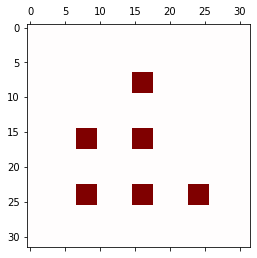

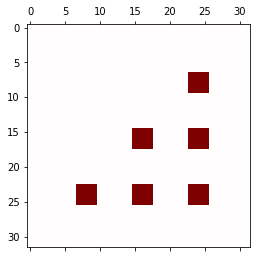

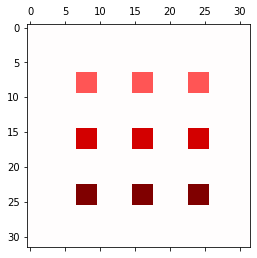

In [7]:
#Plot the three template images and the averge template image
clim = np.abs(temp_0).max()
plt.matshow(temp_0,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_1).max()
plt.matshow(temp_1,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_2).max()
plt.matshow(temp_2,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_avg).max()
plt.matshow(temp_avg,cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [8]:
#Get difference maps for the avg template with respect to the other templates
diff_0 = temp_0 - temp_avg
diff_1 = temp_1 - temp_avg
diff_2 = temp_2 - temp_avg

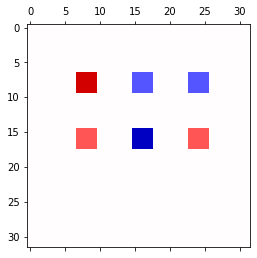

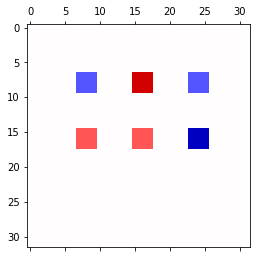

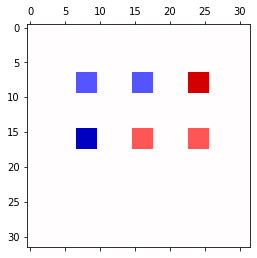

In [9]:
#Plot the difference maps for the avg template with respect to the other templates
plt.matshow(diff_0,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(diff_1,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(diff_2,cmap='seismic',vmin=-1.0,vmax=1)

In [10]:
#Declare Tensorflow input and output tensors

x = tf.placeholder(tf.float32, (None, 32,32), name = 'x')
        
y_true = tf.placeholder(tf.int64, (None), name='y')

x_flat = tf.contrib.layers.flatten(x)

mask_true = tf.one_hot(y_true,3)

In [11]:
#Declare linear model
with tf.variable_scope('l'):
    
    y_logits_l = tf.contrib.layers.fully_connected(x_flat,3,weights_regularizer=tf.keras.regularizers.l2(l=1e-5),activation_fn=None)

    y_logits_l = y_logits_l

    loss_l = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_l)

    probs_l = tf.nn.softmax(y_logits_l)

    acc_l = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_l, 1)),tf.float32))

    train_l = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_l)

    masked_loss_l = tf.reduce_sum( probs_l * mask_true,axis = -1)

    masked_logits_l = tf.reduce_sum(y_logits_l  * mask_true,axis = -1)

    w = tf.gradients(masked_logits_l,x)

    g_l = tf.gradients(masked_loss_l,x)

In [12]:
#Declare neural network model
with tf.variable_scope('nn'):
    h_nn = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_nn = tf.contrib.layers.fully_connected(h_nn,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_nn = y_logits_nn

    loss_nn = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_nn)

    probs_nn = tf.nn.softmax(y_logits_nn)

    loss_nn = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_nn)

    acc_nn = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_nn, 1)),tf.float32))

    train_nn = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_nn)

    masked_loss_nn = tf.reduce_sum( probs_nn * mask_true,axis = -1)

    masked_logits_nn = tf.reduce_sum( y_logits_nn * mask_true,axis = -1)

    g_nn = tf.gradients(masked_loss_nn,x)

In [13]:
#Declare neural network with random spherical noise model
with tf.variable_scope('sph'):
    h_sph = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sph = tf.contrib.layers.fully_connected(h_sph,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sph = y_logits_sph

    loss_sph = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sph)

    probs_sph = tf.nn.softmax(y_logits_sph)

    loss_sph = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sph)

    acc_sph = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_sph, 1)),tf.float32))

    train_sph = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_sph)

    masked_loss_sph = tf.reduce_sum( probs_sph * mask_true,axis = -1)

    masked_logits_sph = tf.reduce_sum( y_logits_sph * mask_true,axis = -1)

    g_sph = tf.gradients(masked_loss_sph,x)

In [14]:
#Declare neural network with advesarial training model 
with tf.variable_scope('adv'):
    
    h_adv = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_adv = tf.contrib.layers.fully_connected(h_adv,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    loss_adv = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_adv)

    probs_adv = tf.nn.softmax(y_logits_adv)

    acc_adv = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_adv, 1)),tf.float32))

    train_adv = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_adv)

    masked_loss_adv = tf.reduce_sum( probs_adv * mask_true,axis = -1)

    masked_logits_adv = tf.reduce_sum(y_logits_adv * mask_true,axis = -1)

    g_adv = tf.gradients(masked_loss_adv,x)

In [15]:
#Declare model savers
vars_l = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='l')
saver_l = tf.train.Saver(vars_l)
vars_nn = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='nn')
saver_nn = tf.train.Saver(vars_nn)
vars_sph = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='sph')
saver_sph = tf.train.Saver(vars_sph)
vars_adv = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='adv')
saver_adv = tf.train.Saver(vars_adv)

In [16]:
#Train linear model
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_l, a_l = sess.run([train_l, loss_l, acc_l], feed_dict={x: train_data, y_true: train_labels})
        print('Loss L: ' + str(l_l[0]))
        print('Acc L: ' + str(a_l))
    saver_l.save(sess, "saved_models/model_l.ckpt", write_meta_graph=False)

Loss L: 1.1514229
Acc L: 0.28840908
Loss L: 1.1489468
Acc L: 0.29920456
Loss L: 1.1480258
Acc L: 0.30875
Loss L: 1.1467236
Acc L: 0.3181818
Loss L: 1.1444762
Acc L: 0.33034092
Loss L: 1.1409764
Acc L: 0.3440909
Loss L: 1.1360773
Acc L: 0.35840908
Loss L: 1.1296842
Acc L: 0.37579545
Loss L: 1.1216753
Acc L: 0.39352274
Loss L: 1.1119254
Acc L: 0.41329545
Loss L: 1.1003163
Acc L: 0.43477273
Loss L: 1.0867825
Acc L: 0.45318183
Loss L: 1.0713527
Acc L: 0.47454545
Loss L: 1.0541489
Acc L: 0.49863636
Loss L: 1.0353559
Acc L: 0.5198864
Loss L: 1.0151837
Acc L: 0.5426136
Loss L: 0.99385786
Acc L: 0.5631818
Loss L: 0.9716108
Acc L: 0.58602273
Loss L: 0.9486608
Acc L: 0.6093182
Loss L: 0.9251866
Acc L: 0.6323864
Loss L: 0.9013202
Acc L: 0.6547727
Loss L: 0.87717134
Acc L: 0.67704546
Loss L: 0.852853
Acc L: 0.6989773
Loss L: 0.82848495
Acc L: 0.7211364
Loss L: 0.80417675
Acc L: 0.7411364
Loss L: 0.780012
Acc L: 0.7618182
Loss L: 0.7560535
Acc L: 0.77931815
Loss L: 0.73235935
Acc L: 0.7975
Loss L: 

In [17]:
#Get validation results for the linear model with different temperatures
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    l_l, a_l = sess.run([loss_l, acc_l], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_l[0]))
    print('Acc L: ' + str(a_l))


INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt
Loss L: 0.48560917
Acc L: 0.99


In [18]:
#Get test results for the linear model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    l_l, a_l = sess.run([loss_l, acc_l], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_l[0]))
    print('Acc L: ' + str(a_l))

INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt
Loss L: 0.20235847
Acc L: 1.0


In [19]:
#Get weights and test data gradients for the linear model

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    #Get weights and gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_l_0, weights_l_0 = sess.run([g_l,w], feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get weights and gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_l_1, weights_l_1 = sess.run([g_l,w], feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get weights and gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_l_2, weights_l_2 = sess.run([g_l,w], feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get weights and gradients for class 1 for class 0 inputs
    grad_l_0_1, weights_l_0_1 = sess.run([g_l,w], feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get weights and gradients for class 2 for class 0 inputs
    grad_l_0_2, weights_l_0_2 = sess.run([g_l,w], feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get weights and gradients for class 0 for class 1 inputs 
    grad_l_1_0, weights_l_1_0 = sess.run([g_l,w], feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get weights and gradients for class 2 for class 1 inputs
    grad_l_1_2, weights_l_1_2 = sess.run([g_l,w], feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get weights and gradients for class 0 for class 2 inputs
    grad_l_2_0, weights_l_2_0 = sess.run([g_l,w], feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get weights and gradients for class 1 for class 2 inputs
    grad_l_2_1, weights_l_2_1 = sess.run([g_l,w], feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt


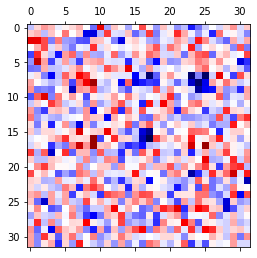

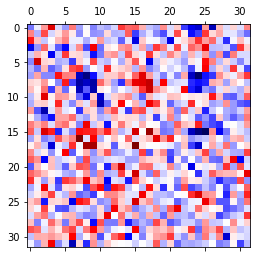

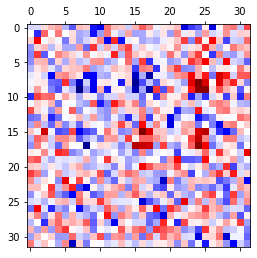

In [20]:
#Plot linear model weights for the three classes
#Plot weights for class 0
clim = np.abs(weights_l_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)
#Plot weights for class 1
clim = np.abs(weights_l_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)
#Plot weights for class 2
clim = np.abs(weights_l_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

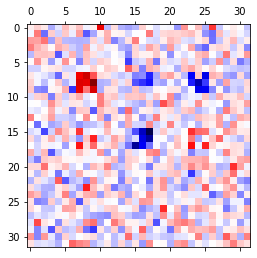

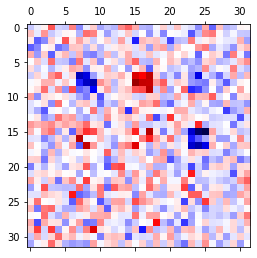

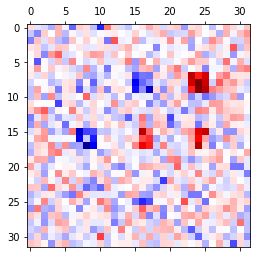

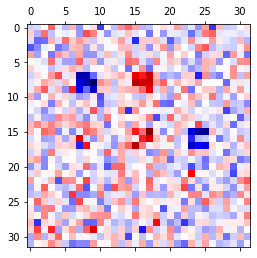

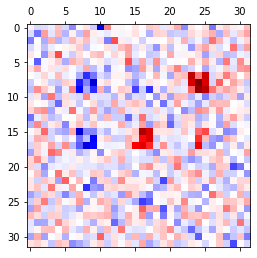

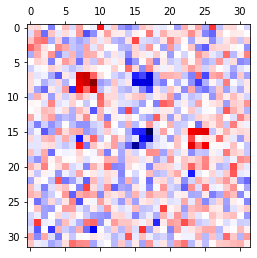

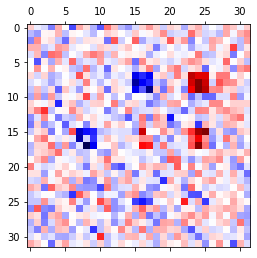

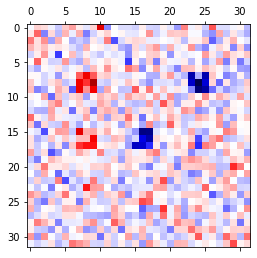

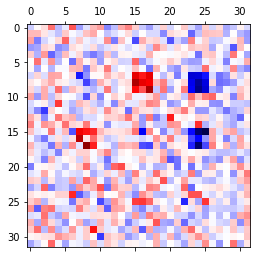

In [21]:
#Plot gradients for the linear model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_l_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_l_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_l_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_l_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_l_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_l_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_l_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_l_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_l_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_l_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [22]:
#Train neural network model
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_nn, a_nn = sess.run([train_nn, loss_nn, acc_nn], feed_dict={x: train_data, y_true: train_labels})
        print('Loss L: ' + str(l_nn[0]))
        print('Acc L: ' + str(a_nn))
    saver_nn.save(sess, "saved_models/model_nn.ckpt", write_meta_graph=False)

Loss L: 2.107201
Acc L: 0.33227274
Loss L: 2.0010493
Acc L: 0.3519318
Loss L: 1.8938195
Acc L: 0.37761363
Loss L: 1.7912612
Acc L: 0.40431818
Loss L: 1.7049246
Acc L: 0.43386364
Loss L: 1.6277981
Acc L: 0.465
Loss L: 1.548954
Acc L: 0.49602273
Loss L: 1.4728488
Acc L: 0.52420455
Loss L: 1.4014649
Acc L: 0.55056816
Loss L: 1.3355737
Acc L: 0.5784091
Loss L: 1.27548
Acc L: 0.6052273
Loss L: 1.2208663
Acc L: 0.6298864
Loss L: 1.1754072
Acc L: 0.65261364
Loss L: 1.1346284
Acc L: 0.67704546
Loss L: 1.097811
Acc L: 0.69511366
Loss L: 1.0643687
Acc L: 0.7170454
Loss L: 1.0339977
Acc L: 0.73375
Loss L: 1.009023
Acc L: 0.7506818
Loss L: 0.9875295
Acc L: 0.76920456
Loss L: 0.96776974
Acc L: 0.78568184
Loss L: 0.94940233
Acc L: 0.8028409
Loss L: 0.9321267
Acc L: 0.81886363
Loss L: 0.9158068
Acc L: 0.83522725
Loss L: 0.9021482
Acc L: 0.85011363
Loss L: 0.88923717
Acc L: 0.8636364
Loss L: 0.87608284
Acc L: 0.8782955
Loss L: 0.86204517
Acc L: 0.8925
Loss L: 0.8469754
Acc L: 0.9060227
Loss L: 0.83070

In [23]:
#Get validation results for the neural network model with different temperatures
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    l_nn, a_nn = sess.run([loss_nn, acc_nn], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_nn[0]))
    print('Acc L: ' + str(a_nn))

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt
Loss L: 0.07296866
Acc L: 1.0


In [24]:
#Get test results for the neural network model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    l_nn, a_nn = sess.run([loss_nn, acc_nn], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_nn[0]))
    print('Acc L: ' + str(a_nn))

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt
Loss L: 0.0687201
Acc L: 1.0


In [25]:
#Get test data gradients for the neural network model

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_nn_0 = sess.run(g_nn, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    gradxi_nn_0 = grad_nn_0 * x_0
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_nn_1 = sess.run(g_nn, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    gradxi_nn_1 = grad_nn_1 * x_1
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_nn_2 = sess.run(g_nn, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    gradxi_nn_2 = grad_nn_2 * x_2
    
    #Get gradients for class 1 for class 0 inputs
    grad_nn_0_1 = sess.run(g_nn, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    gradxi_nn_0_1 = grad_nn_0_1 * x_0
    
    #Get gradients for class 2 for class 0 inputs
    grad_nn_0_2 = sess.run(g_nn, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    gradxi_nn_0_2 = grad_nn_0_2 * x_0
    
    #Get gradients for class 0 for class 1 inputs 
    grad_nn_1_0 = sess.run(g_nn, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    gradxi_nn_1_0 = grad_nn_1_0 * x_1
    
    #Get gradients for class 2 for class 1 inputs
    grad_nn_1_2 = sess.run(g_nn, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    gradxi_nn_1_2 = grad_nn_1_2 * x_1

    #Get gradients for class 0 for class 2 inputs
    grad_nn_2_0 = sess.run(g_nn, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    gradxi_nn_2_0 = grad_nn_2_0 * x_2
    
    #Get gradients for class 1 for class 2 inputs
    grad_nn_2_1 = sess.run(g_nn, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})
    
    gradxi_nn_2_1 = grad_nn_2_1 * x_2

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt


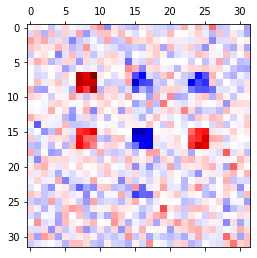

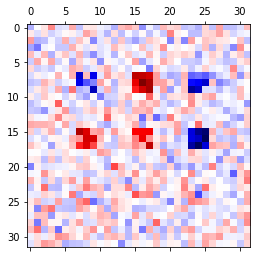

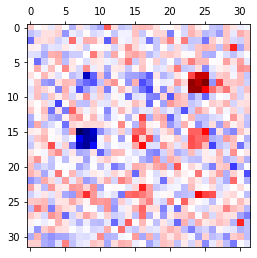

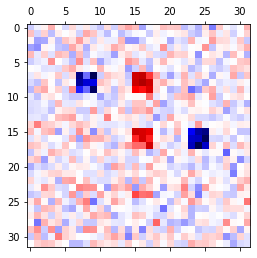

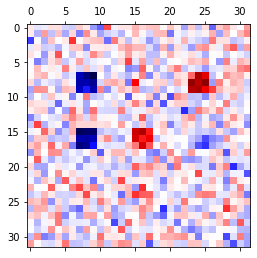

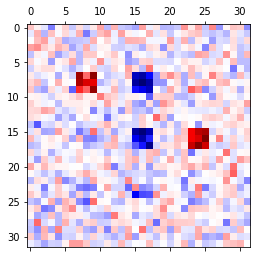

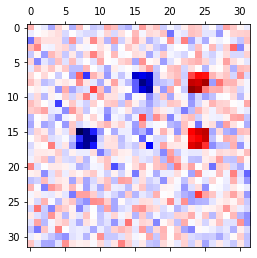

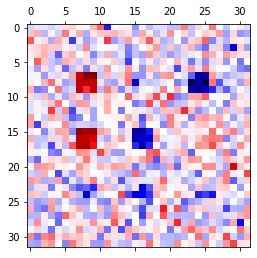

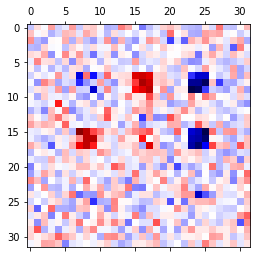

In [26]:
#Plot gradients for the neural network model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_nn_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_nn_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_nn_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_nn_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_nn_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_nn_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_nn_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_nn_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_nn_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_nn_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

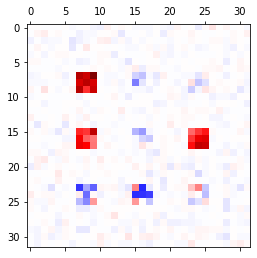

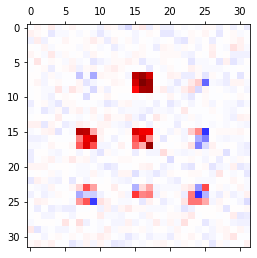

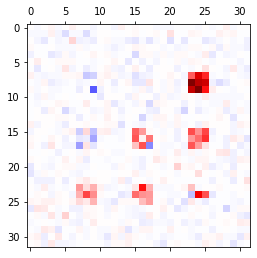

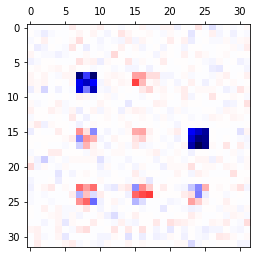

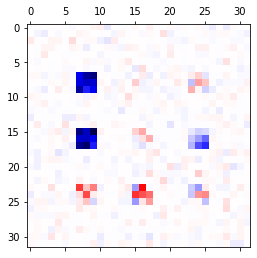

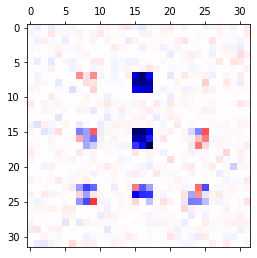

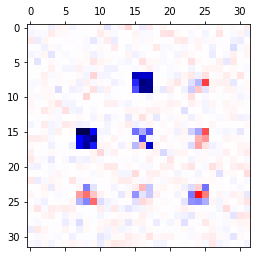

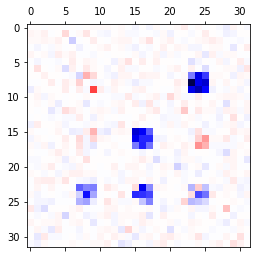

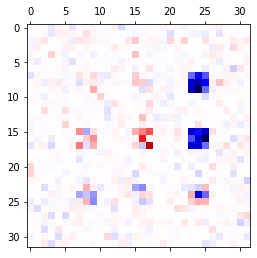

In [27]:
#Plot gradients for the neural network model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(gradxi_nn_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(gradxi_nn_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(gradxi_nn_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(gradxi_nn_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(gradxi_nn_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(gradxi_nn_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(gradxi_nn_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(gradxi_nn_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(gradxi_nn_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(gradxi_nn_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [28]:
#Get test data gradients for the neural network model with SmoothGrad

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: test_labels[where_test_0[0]]})[0])
    grad_sg_0 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: test_labels[where_test_1[0]]})[0])
    grad_sg_1 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: test_labels[where_test_2[0]]})[0])
    grad_sg_2 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 1 for class 0 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)})[0])
    grad_sg_0_1 = np.array(grads).mean(axis=0,keepdims=True)  
    
    #Get gradients for class 2 for class 0 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)})[0])
    grad_sg_0_2 = np.array(grads).mean(axis=0,keepdims=True)  
    
    #Get gradients for class 0 for class 1 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)})[0])
    grad_sg_1_0 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 2 for class 1 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)})[0])
    grad_sg_1_2 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 0 for class 2 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)})[0])
    grad_sg_2_0 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 1 for class 2 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})[0])
    grad_sg_2_1 = np.array(grads).mean(axis=0,keepdims=True)

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt


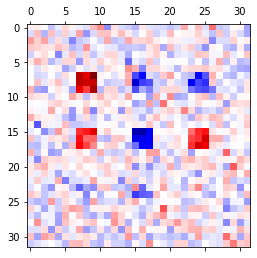

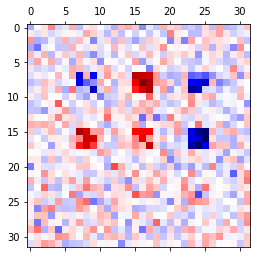

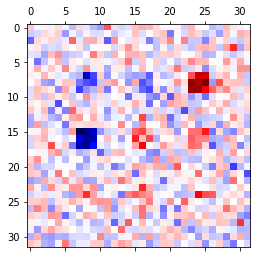

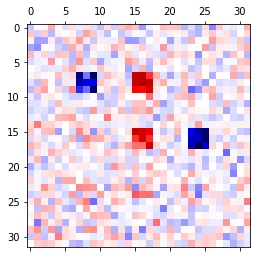

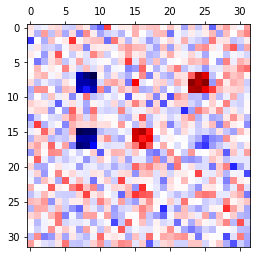

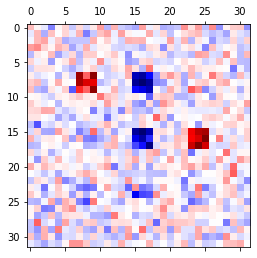

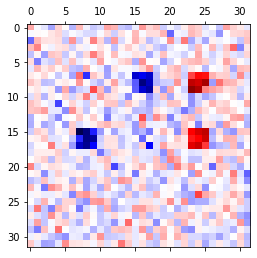

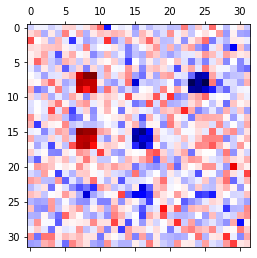

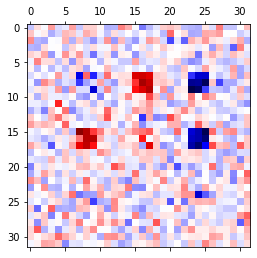

In [29]:
#Plot gradients for the neural network model with SmoothGrad

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_sg_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_sg_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_sg_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_sg_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_sg_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_sg_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_sg_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_sg_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_sg_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sg_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [30]:
#Define function to generate uniform spherical noise
def get_sph_noise(shape,epsilon):
    n_noise_samples = shape[0]
    shape.pop(0)
    noise = []
    for n in range(n_noise_samples):
        noise_tmp = np.random.normal(size=shape)
        u = np.random.uniform(size=())
        noise_tmp = (epsilon*(u**(1.0/float(np.prod(np.array(shape))))) * noise_tmp / (np.linalg.norm(noise_tmp)+1e-16))  
        noise.append(noise_tmp)
    return np.array(noise)

In [31]:
#Train neural network model with random spherical noise
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        noise = get_sph_noise(list(train_data.shape),1.0)
        _, l_sph, a_sph = sess.run([train_sph, loss_sph, acc_sph], feed_dict={x: train_data+noise, y_true: train_labels})
        print('Loss L: ' + str(l_sph[0]))
        print('Acc L: ' + str(a_sph))
    saver_sph.save(sess, "saved_models/model_sph.ckpt", write_meta_graph=False)

Loss L: 1.3595917
Acc L: 0.32920456
Loss L: 1.3008081
Acc L: 0.37113637
Loss L: 1.3177289
Acc L: 0.41579545
Loss L: 1.2437057
Acc L: 0.4646591
Loss L: 1.2329637
Acc L: 0.5175
Loss L: 1.1606244
Acc L: 0.5648864
Loss L: 1.1379366
Acc L: 0.6146591
Loss L: 1.1228738
Acc L: 0.65977275
Loss L: 1.0913128
Acc L: 0.7013636
Loss L: 1.0246128
Acc L: 0.74147725
Loss L: 0.9679487
Acc L: 0.77772725
Loss L: 0.9099175
Acc L: 0.8101136
Loss L: 0.85335577
Acc L: 0.8430682
Loss L: 0.80947065
Acc L: 0.8678409
Loss L: 0.7430917
Acc L: 0.89204544
Loss L: 0.71950257
Acc L: 0.91011363
Loss L: 0.65282327
Acc L: 0.9285227
Loss L: 0.64703715
Acc L: 0.9432955
Loss L: 0.58709246
Acc L: 0.9530682
Loss L: 0.56688714
Acc L: 0.9647727
Loss L: 0.49339795
Acc L: 0.9720455
Loss L: 0.44302082
Acc L: 0.9802273
Loss L: 0.39225158
Acc L: 0.9853409
Loss L: 0.32866228
Acc L: 0.9893182
Loss L: 0.32944
Acc L: 0.9911364
Loss L: 0.32738915
Acc L: 0.99295455
Loss L: 0.25638002
Acc L: 0.9952273
Loss L: 0.24616449
Acc L: 0.99613637
L

In [32]:
#Get validation results for the neural network model trained with spherical noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    l_sph, a_sph = sess.run([loss_sph, acc_sph], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_sph[0]))
    print('Acc L: ' + str(a_sph))

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt
Loss L: 0.08127344
Acc L: 1.0


In [33]:
#Get test results for the neural network model trained with spherical noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    l_sph, a_sph = sess.run([loss_sph, acc_sph], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_sph[0]))
    print('Acc L: ' + str(a_sph))

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt
Loss L: 0.07902315
Acc L: 1.0


In [34]:
#Get test data gradients for the neural network model trained with spherical noise

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_sph_0 = sess.run(g_sph, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_sph_1 = sess.run(g_sph, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_sph_2 = sess.run(g_sph, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get gradients for class 1 for class 0 inputs
    grad_sph_0_1 = sess.run(g_sph, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 2 for class 0 inputs
    grad_sph_0_2 = sess.run(g_sph, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 0 for class 1 inputs 
    grad_sph_1_0 = sess.run(g_sph, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 2 for class 1 inputs
    grad_sph_1_2 = sess.run(g_sph, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 0 for class 2 inputs
    grad_sph_2_0 = sess.run(g_sph, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get gradients for class 1 for class 2 inputs
    grad_sph_2_1 = sess.run(g_sph, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt


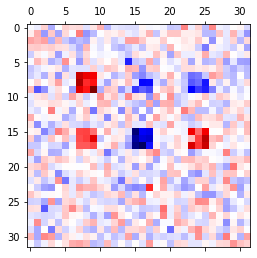

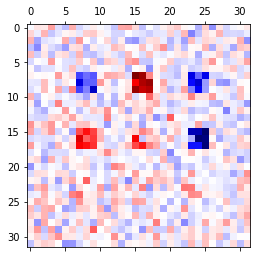

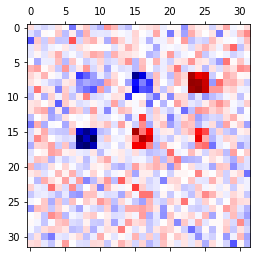

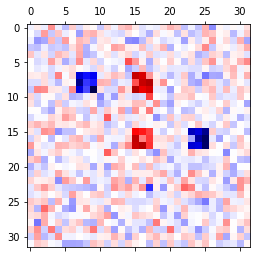

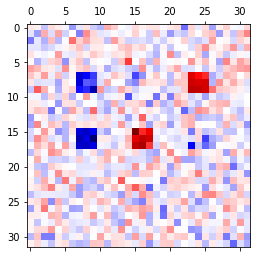

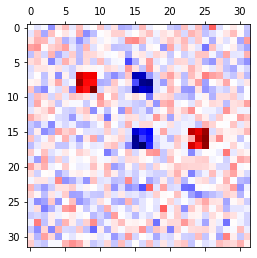

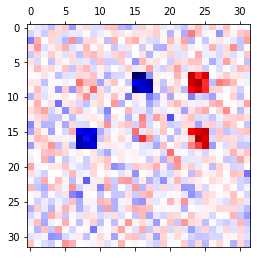

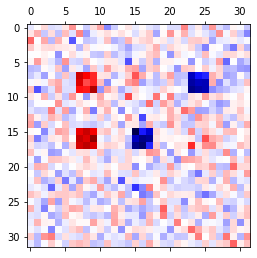

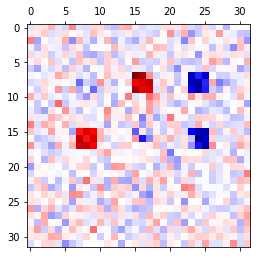

In [35]:
#Plot gradients for the neural network model trained with spherical noise

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_sph_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_sph_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_sph_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_sph_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_sph_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_sph_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_sph_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_sph_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_sph_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_sph_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [125]:
#Train neural network model with adversarial noise
n_ep = 50
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_adv, a_adv, grads_adv = sess.run([train_adv, loss_adv, acc_adv, g_adv], feed_dict={x: train_data, y_true: train_labels})
        del_1 = grads_adv[0]
        norm_del_1 = np.linalg.norm(del_1,axis=(1,2))
        norm_where = np.where(norm_del_1>0.0)
        norm_del_1 = np.reshape(norm_del_1,(-1,1,1))
        del_1[norm_where] = del_1[norm_where] / norm_del_1[norm_where]
        del_1 *= -1.0
        del_2 = sess.run(g_adv, feed_dict={x: train_data + del_1, y_true: train_labels})[0]
        norm_del_2 = np.linalg.norm(del_2,axis=(1,2))
        norm_where = np.where(norm_del_2>0.0)
        norm_del_2 = np.reshape(norm_del_2,(-1,1,1))
        del_2[norm_where] = del_2[norm_where] / norm_del_2[norm_where]
        del_2 = del_1 - 1.0 * del_2
        del_3 = sess.run(g_adv, feed_dict={x: train_data + del_2, y_true: train_labels})[0]
        norm_del_3 = np.linalg.norm(del_3,axis=(1,2))
        norm_where = np.where(norm_del_3>0.0)
        norm_del_3 = np.reshape(norm_del_3,(-1,1,1))
        del_3[norm_where] = del_3[norm_where] / norm_del_3[norm_where]
        del_3 = del_2 - 1.0 * del_3
        norm_del_3 =  np.linalg.norm(del_3,axis=(1,2))
        norm_where = np.where(norm_del_3>1.0)
        norm_del_3 = np.reshape(norm_del_3,(-1,1,1))
        if len(norm_where) > 0:
            del_3[norm_where] = 1.0 * del_3[norm_where] / norm_del_3[norm_where] 
        _ = sess.run(train_adv, feed_dict={x: (train_data + del_3), y_true: train_labels})
        print('Loss L: ' + str(l_adv[0]))
        print('Acc L: ' + str(a_adv))
    saver_adv.save(sess, "saved_models/model_adv.ckpt", write_meta_graph=False)

/data/MLcore/miniconda3/envs/tf_john/lib/python3.6/site-packages/numpy/linalg/linalg.py:2428: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(add.reduce((x.conj() * x).real, axis=axis))


Loss L: 0.92035836
Acc L: 0.32431817
Loss L: 0.8640931
Acc L: 0.37147728
Loss L: 0.8608744
Acc L: 0.43647727
Loss L: 0.8576443
Acc L: 0.51511365
Loss L: 0.85475117
Acc L: 0.6128409
Loss L: 0.8432727
Acc L: 0.7113636
Loss L: 0.8257654
Acc L: 0.7911364
Loss L: 0.80046535
Acc L: 0.8527273
Loss L: 0.76360136
Acc L: 0.89852273
Loss L: 0.70336187
Acc L: 0.9372727
Loss L: 0.63880366
Acc L: 0.96340907
Loss L: 0.5597353
Acc L: 0.9819318
Loss L: 0.47505748
Acc L: 0.9909091
Loss L: 0.3948058
Acc L: 0.9967045
Loss L: 0.3249176
Acc L: 0.9984091
Loss L: 0.2656597
Acc L: 0.9993182
Loss L: 0.21631545
Acc L: 0.9997727
Loss L: 0.17601235
Acc L: 0.99988633
Loss L: 0.14360003
Acc L: 1.0
Loss L: 0.117863245
Acc L: 1.0
Loss L: 0.09820367
Acc L: 1.0
Loss L: 0.082625
Acc L: 1.0
Loss L: 0.069997475
Acc L: 1.0
Loss L: 0.05964747
Acc L: 1.0
Loss L: 0.05124169
Acc L: 1.0
Loss L: 0.044207904
Acc L: 1.0
Loss L: 0.03813494
Acc L: 1.0
Loss L: 0.033191178
Acc L: 1.0
Loss L: 0.029287219
Acc L: 1.0
Loss L: 0.02574933
Ac

In [126]:
#Get validation results for the neural network model trained with adversarial noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    l_adv, a_adv = sess.run([loss_adv, acc_adv], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_adv[0]))
    print('Acc L: ' + str(a_adv))

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt
Loss L: 0.03981471
Acc L: 1.0


In [127]:
#Get test results for the neural network model trained with adversarial noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    l_adv, a_adv = sess.run([loss_adv, acc_adv], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_adv[0]))
    print('Acc L: ' + str(a_adv))

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt
Loss L: 0.027945371
Acc L: 1.0


In [128]:
#Get test data gradients for the neural network model trained with adversarial noise

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_adv_0 = sess.run(g_adv, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_adv_1 = sess.run(g_adv, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_adv_2 = sess.run(g_adv, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get gradients for class 1 for class 0 inputs
    grad_adv_0_1 = sess.run(g_adv, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 2 for class 0 inputs
    grad_adv_0_2 = sess.run(g_adv, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 0 for class 1 inputs 
    grad_adv_1_0 = sess.run(g_adv, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 2 for class 1 inputs
    grad_adv_1_2 = sess.run(g_adv, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 0 for class 2 inputs
    grad_adv_2_0 = sess.run(g_adv, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get gradients for class 1 for class 2 inputs
    grad_adv_2_1 = sess.run(g_adv, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt


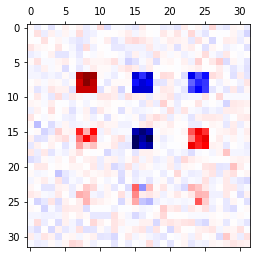

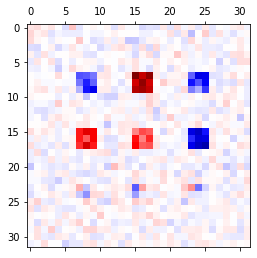

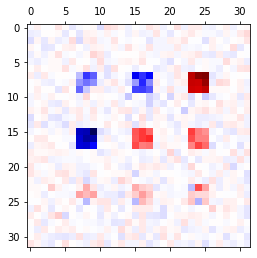

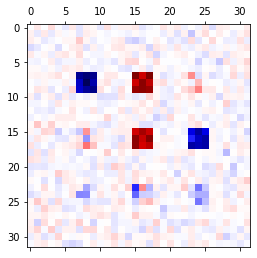

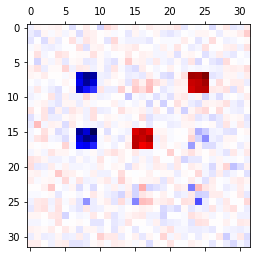

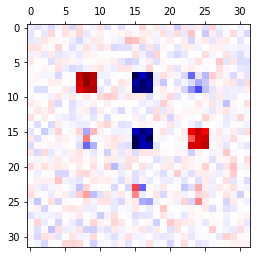

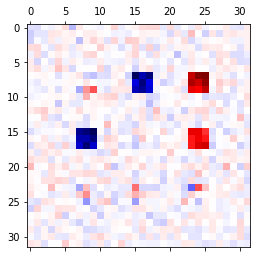

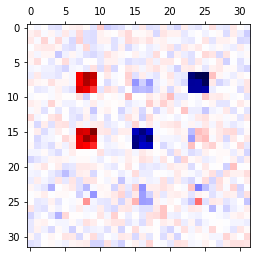

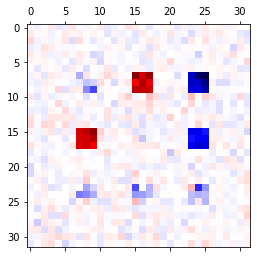

In [129]:
#Plot gradients for the neural network model trained with adversarial noise

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_adv_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_adv_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_adv_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_adv_0_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_0_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_adv_0_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_0_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_adv_1_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_1_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_adv_1_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_1_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_adv_2_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_2_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_adv_2_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(grad_adv_2_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [130]:
from scipy.stats import pearsonr
from scipy.stats import ttest_rel

In [131]:
#Correlation between the class 0 template minus the average template and the class 0 weights
pearsonr(np.reshape(weights_l_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.36300224009741694, 2.9968475301484212e-33)

In [132]:
#Correlation between the class 0 template minus the average template and the average class 0 linear model gradient for class 0 inputs
pearsonr(np.reshape(grad_l_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.5265775614395629, 4.046212809483107e-74)

In [133]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network gradient for class 0 inputs
pearsonr(np.reshape(grad_nn_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.7106195307454848, 3.14215010639801e-158)

In [134]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network gradientxinput for class 0 inputs
pearsonr(np.reshape(gradxi_nn_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.6764081648155622, 6.810984126769789e-138)

In [135]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network trained with spherical noise gradient for class 0 inputs
pearsonr(np.reshape(grad_sph_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.702158991407031, 6.27158394804734e-153)

In [136]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network SmoothGrad gradient for class 0 inputs
pearsonr(np.reshape(grad_sg_0.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.7123497359135678, 2.452777966821006e-159)

In [137]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network with adversarial training gradient for class 0 inputs
pearsonr(np.reshape(grad_adv_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.9326369248396132, 0.0)

In [138]:
#Correlation between the class 1 template minus the average template and the class 1 weights
pearsonr(np.reshape(weights_l_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.3804580018424246, 1.3011866099655082e-36)

In [139]:
#Correlation between the class 1 template minus the average template and the average class 1 linear model gradient for class 1 inputs
pearsonr(np.reshape(grad_l_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.5264910054318518, 4.3162551413398774e-74)

In [140]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network gradient for class 1 inputs
pearsonr(np.reshape(grad_nn_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.7212001532563472, 3.917224985639982e-165)

In [141]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network gradientxinput for class 1 inputs
pearsonr(np.reshape(gradxi_nn_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.6650483823658123, 9.742913561865422e-132)

In [142]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network trained with spherical noise gradient for class 1 inputs
pearsonr(np.reshape(grad_sph_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.7329071633147601, 3.717717773667554e-173)

In [143]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network SmoothGrad gradient for class 1 inputs
pearsonr(np.reshape(grad_sg_1.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.7191243293784905, 9.389646797263364e-164)

In [144]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network with adversarial training gradient for class 1 inputs
pearsonr(np.reshape(grad_adv_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.9075154576871188, 0.0)

In [145]:
#Correlation between the class 2 template minus the average template and the class 2 weights
pearsonr(np.reshape(weights_l_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.4045775918875394, 1.3167433569838165e-41)

In [146]:
#Correlation between the class 2 template minus the average template and the average class 2 linear model gradient for class 2 inputs
pearsonr(np.reshape(grad_l_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.5721696338199221, 4.262875320263898e-90)

In [147]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network gradient for class 2 inputs
pearsonr(np.reshape(grad_nn_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.6173455788962373, 1.3133478527786008e-108)

In [148]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network gradientxinput for class 2 inputs
pearsonr(np.reshape(gradxi_nn_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.626008977873698, 1.6434460285345094e-112)

In [149]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network trained with spherical noise gradient for class 2 inputs
pearsonr(np.reshape(grad_sph_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.7262476752939913, 1.531707772098569e-168)

In [150]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network SmoothGrad gradient for class 2 inputs
pearsonr(np.reshape(grad_sg_2.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.6308360963059408, 9.710690992823377e-115)

In [151]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network with adversarial training gradient for class 2 inputs
pearsonr(np.reshape(grad_adv_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.9216662825579538, 0.0)

In [152]:
#Get the correlation between the class template minus the average template and the respective weights for each input
corrs_weights = []
for i in range(weights_l_0[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(weights_l_1[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(weights_l_2[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [153]:
#Get the correlation between the class template minus the average template and the respective linear model gradient for each input
corrs_grad_l = []
for i in range(grad_l_0[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_l_1[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_l_2[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [154]:
#Get the correlation between the class template minus the average template and the respective neural network gradient for each input
corrs_grad_nn = []
for i in range(grad_nn_0[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_nn_1[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_nn_2[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [155]:
#Get the correlation between the class template minus the average template and the respective neural network gradient for each input
corrs_gradxi_nn = []
for i in range(gradxi_nn_0[0].shape[0]):
    corrs_gradxi_nn.append(pearsonr(np.reshape(gradxi_nn_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(gradxi_nn_1[0].shape[0]):
    corrs_gradxi_nn.append(pearsonr(np.reshape(gradxi_nn_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(gradxi_nn_2[0].shape[0]):
    corrs_gradxi_nn.append(pearsonr(np.reshape(gradxi_nn_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [156]:
#Get the correlation between the class template minus the average template and the respective neural network trained with spherical noise gradient for each input
corrs_grad_sph = []
for i in range(grad_sph_0[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_sph_1[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_sph_2[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [157]:
#Get the correlation between the class template minus the average template and the respective neural network SmoothGrad gradient for each input
corrs_grad_sg = []
for i in range(grad_sg_0[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_sg_1[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_sg_2[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [158]:
#Get the correlation between the class template minus the average template and the respective neural network with adversarial training gradient for each input
corrs_grad_adv = []
for i in range(grad_adv_0[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_adv_1[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_adv_2[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [159]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights,corrs_grad_l)

Ttest_relResult(statistic=-83.09224148638909, pvalue=2.2256118359168757e-93)

In [160]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights,corrs_grad_nn)

Ttest_relResult(statistic=-28.24585231690966, pvalue=3.570494394276192e-49)

In [161]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network gradientsxinputs
ttest_rel(corrs_weights,corrs_gradxi_nn)

Ttest_relResult(statistic=-8.051028419512663, pvalue=1.8660315648927948e-12)

In [162]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network trained with spherical noise gradients
ttest_rel(corrs_weights,corrs_grad_sph)

Ttest_relResult(statistic=-55.90898818552144, pvalue=1.0534526126106602e-76)

In [163]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network SmoothGrad gradients
ttest_rel(corrs_weights,corrs_grad_sg)

Ttest_relResult(statistic=-34.80349282264444, pvalue=2.478005630368048e-57)

In [164]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network with adversarial training gradients
ttest_rel(corrs_weights,corrs_grad_adv)

Ttest_relResult(statistic=-74.11201388091794, pvalue=1.540880226604568e-88)

In [165]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l,corrs_grad_nn)

Ttest_relResult(statistic=-9.32152962190678, pvalue=3.3041500593223068e-15)

In [166]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradientsxinputs and the neural network gradients
ttest_rel(corrs_grad_l,corrs_gradxi_nn)

Ttest_relResult(statistic=10.023088529238883, pvalue=9.741926966572696e-17)

In [167]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_l,corrs_grad_sph)

Ttest_relResult(statistic=-24.501998267069713, pvalue=8.074006066397234e-44)

In [168]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_l,corrs_grad_sg)

Ttest_relResult(statistic=-13.255405035576665, pvalue=1.1419933504794899e-23)

In [169]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_l,corrs_grad_adv)

Ttest_relResult(statistic=-51.6039511098482, pvalue=2.261588195988779e-73)

In [170]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network gradientsxinputs
ttest_rel(corrs_grad_nn,corrs_gradxi_nn)

Ttest_relResult(statistic=22.43071282653318, pvalue=1.3496359870171175e-40)

In [171]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_nn,corrs_grad_sph)

Ttest_relResult(statistic=-5.544232614865957, pvalue=2.4538260625522476e-07)

In [172]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_nn,corrs_grad_sg)

Ttest_relResult(statistic=-8.735682240413807, pvalue=6.215410800605377e-14)

In [173]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_nn,corrs_grad_adv)

Ttest_relResult(statistic=-35.573739135824376, pvalue=3.3261425164229786e-58)

In [174]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradientsxinputs and the neural network trained with spherical noise gradients
ttest_rel(corrs_gradxi_nn,corrs_grad_sph)

Ttest_relResult(statistic=-24.003721757333665, pvalue=4.617819426833405e-43)

In [175]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradientsxinputs and the neural network SmoothGrad gradients
ttest_rel(corrs_gradxi_nn,corrs_grad_sg)

Ttest_relResult(statistic=-25.08634307879646, pvalue=1.0787788964033098e-44)

In [176]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradientsxinputs and the neural network with adversarial training gradients
ttest_rel(corrs_gradxi_nn,corrs_grad_adv)

Ttest_relResult(statistic=-50.29088397716569, pvalue=2.644033048716793e-72)

In [177]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network trained with spherical gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_sph,corrs_grad_sg)

Ttest_relResult(statistic=2.945125035368163, pvalue=0.00402383169367705)

In [178]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network trained with spherical gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sph,corrs_grad_adv)

Ttest_relResult(statistic=-31.425385626995453, pvalue=2.646829501329114e-53)

In [179]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sg,corrs_grad_adv)

Ttest_relResult(statistic=-35.266816242323664, pvalue=7.37095322486843e-58)

In [180]:
#Get average correlation between the incorrect class weights and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(weights_l_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(weights_l_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(weights_l_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(weights_l_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(weights_l_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(weights_l_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.33140997091185886

In [181]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_l_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_l_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_l_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_l_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_l_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_l_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.5424238322391697

In [182]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_nn_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_nn_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_nn_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_nn_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_nn_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_nn_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.6877737338320089

In [183]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(gradxi_nn_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.6467510839707437

In [184]:
#Get average correlation between the incorrect class neural network trained with spherical noise gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_sph_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sph_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sph_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sph_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sph_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_sph_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.7210360197159623

In [185]:
#Get average correlation between the incorrect class neural network SmoothGrad gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_sg_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sg_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sg_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sg_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sg_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_sg_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.6910307834592403

In [186]:
#Get average correlation between the incorrect class neural network with adversarial training gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_adv_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_adv_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_adv_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_adv_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_adv_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_adv_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.9240285430390903

In [187]:
#Get average correlation between the incorrect class weights and the respective template difference map for each input
corrs_weights_diffs = []

for i in range(weights_l_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)
    
for i in range(weights_l_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)
for i in range(weights_l_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)

In [188]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for each input
corrs_grad_l_diffs = []

for i in range(grad_l_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_l_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)
for i in range(grad_l_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)

In [189]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for each input
corrs_grad_nn_diffs = []

for i in range(grad_nn_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_nn_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)
for i in range(grad_nn_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)

In [190]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for each input
corrs_gradxi_nn_diffs = []

for i in range(gradxi_nn_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_gradxi_nn_diffs.append(corrs_tmp/2.0)
    
for i in range(gradxi_nn_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_gradxi_nn_diffs.append(corrs_tmp/2.0)
for i in range(gradxi_nn_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_gradxi_nn_diffs.append(corrs_tmp/2.0)

In [191]:
#Get average correlation between the incorrect class neural network trained with spherical noise gradient and the respective template difference map for each input
corrs_grad_sph_diffs = []

for i in range(grad_sph_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_sph_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)
for i in range(grad_sph_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)

In [192]:
#Get average correlation between the incorrect class neural network SmoothGrad gradient and the respective template difference map for each input
corrs_grad_sg_diffs = []

for i in range(grad_sg_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_sg_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)
for i in range(grad_sg_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)

In [193]:
#Get average correlation between the incorrect class neural network with adversarial training gradient and the respective template difference map for each input

corrs_grad_adv_diffs = []

for i in range(grad_adv_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_adv_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)
for i in range(grad_adv_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)

In [194]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights_diffs,corrs_grad_l_diffs)

Ttest_relResult(statistic=-210.35856507293937, pvalue=4.638120532035828e-133)

In [195]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=-60.07108015353562, pvalue=1.0544081430607053e-79)

In [196]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network gradientsxinputs
ttest_rel(corrs_weights_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=-18.820964978170043, pvalue=1.784754448876153e-34)

In [197]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network trained with spherical noise gradients
ttest_rel(corrs_weights_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-82.29399312763005, pvalue=5.7098710394629686e-93)

In [198]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-123.87055474566723, pvalue=2.2194135791684343e-110)

In [199]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=-16.48024647448987, pvalue=3.909937837177022e-30)

In [200]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradientsxinputs
ttest_rel(corrs_grad_l_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=12.300501507407185, pvalue=1.1735305724731764e-21)

In [201]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-31.94780870868321, pvalue=5.98193341150025e-54)

In [202]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-23.540180907516707, pvalue=2.393765308085415e-42)

In [203]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-71.31214427410409, pvalue=6.507350105245597e-87)

In [204]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network gradientsxinputs
ttest_rel(corrs_grad_nn_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=32.22462223578236, pvalue=2.7424041113852483e-54)

In [205]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-5.009912571662825, pvalue=2.381614214830534e-06)

In [206]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-9.110795138989058, pvalue=9.50944332698592e-15)

In [207]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-50.37974669134708, pvalue=2.23454293715953e-72)

In [208]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradientsxinputs and the neural network trained with spherical noise gradients
ttest_rel(corrs_gradxi_nn_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-28.6071381965137, pvalue=1.1623336962621253e-49)

In [209]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradientsxinputs and the neural network SmoothGrad gradients
ttest_rel(corrs_gradxi_nn_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-33.970639580198316, pvalue=2.2689224351174987e-56)

In [210]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradientsxinputs and the neural network with adversarial training gradients
ttest_rel(corrs_gradxi_nn_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-64.15423809072745, pvalue=1.843902362767224e-82)

In [211]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network trained with spherical noise gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_sph_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=2.1580832254275673, pvalue=0.03333960899475801)

In [212]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network trained with spherical noise gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sph_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-43.576367675930975, pvalue=2.0863218647449348e-66)

In [213]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sg_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-53.12690693564429, pvalue=1.402960301542435e-74)